In [1]:
# reuqire backage
import plotly
import pandas
import graphviz 
import imblearn
import pydotplus
import numpy as np
from collections import Counter
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#sklearn
import sklearn
import sklearn.model_selection
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier


**Read the CSV file**

In [2]:
#read files from csv via pandas
df = pandas.read_csv("Pokemon.csv", header = 0)
df = df.drop(columns = ["#"]) # drop id
df["Legendary"] = df["Legendary"].astype('int32') # convert the Legendary boolean to 1 or 0


**EDA works**
- Combines type 1 and type 2 features
- Convert the type into one-hot encoding
- Adding attack damage and defense value
- Drop non-effect features

In [3]:
# TBC
# duplicate the type 2 to another column
type2 = df.loc[df['Type 2'].notnull()] #select the non-null feature 2
type2 = type2.reset_index(drop=True)
type2["Type 1"] = type2["Type 2"]
type2 = type2.drop(columns = ["Type 2"]) # append and drop

# append the type 2 poke to df
df = df.drop(columns = ["Type 2"]) # append it back to orginal 
df = df.append(type2)

In [4]:
# TBC
# convert from types to one-hot 
Type_key = df.groupby("Type 1").groups.keys() # take all the key values
Type = pandas.DataFrame(columns = Type_key) # create the new dataframe base the all the type key found
type1 = df["Type 1"].tolist()
key = list(Type.keys()) # loop over all the types
count = 0
for i in type1:
    value_list = np.zeros(len(key)).reshape(1,len(key)) # default all 0
    value_list = pandas.DataFrame(value_list, columns = key)
    Type = Type.append(value_list) # append the new row into dataframe
    Type.iloc[count][i] = 1 # the select type feature will be 1
    count += 1 # index the current row
    

In [5]:
# TBC
# orgainse new type keys into df 

key_list = df.keys().to_list()
Final_key = key_list[:2] + Type.keys().to_list() + key_list[2:] # re-order the key values

for i in Type.keys():
    df[i] = Type[i].to_list() # add the new key into df
df = df[Final_key]

In [6]:
# Remove All the types
try:
    df = df.drop(columns = ["Name","Type 1", "Type 2"]) # , "Generation"
except:
    df = df.drop(columns = ["Name","Type 1"]) # , "Generation"


# Increase the features into df
df["Attack Output"] = df["Attack"]*df["Sp. Atk"]
df["Defense Output"] = df["Defense"]*df["Sp. Def"]

In [7]:
scale_df = df.drop(columns = ["Legendary"])
keys = list(scale_df.keys())

scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(scale_df)
scale_df = scaler.transform(scale_df)
scale_df = pandas.DataFrame(scale_df, columns = keys)
scale_df["Legendary"] = df["Legendary"].tolist()

In [8]:
df = scale_df

### Feature Importance

#### via Extra Tree Classifier

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(df.drop(columns = ["Legendary"]),df["Legendary"])
importances = forest.feature_importances_

In [10]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,10):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], df.keys()[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 18 Total (0.203040)
2. feature 26 Attack Output (0.126455)
3. feature 22 Sp. Atk (0.104958)
4. feature 20 Attack (0.072445)
5. feature 19 HP (0.071224)
6. feature 24 Speed (0.070127)
7. feature 23 Sp. Def (0.069801)
8. feature 27 Defense Output (0.067160)
9. feature 25 Generation (0.056990)
10. feature 21 Defense (0.050631)


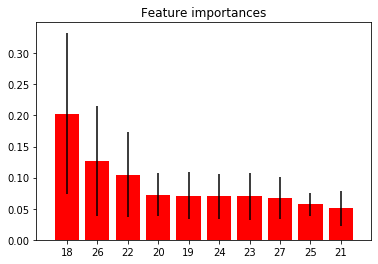

In [11]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices[:10]],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(0,10), indices)
plt.xlim([-1, 10])
plt.show()

#### via XGboost

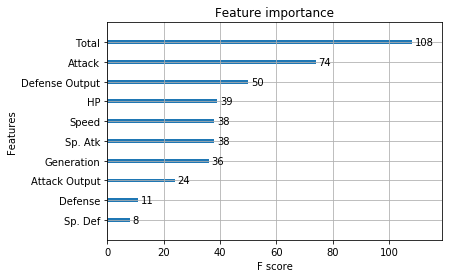

In [12]:
# xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(df.drop(columns = ["Legendary"]), df["Legendary"])

# plot feature importance
plot_importance(model, max_num_features= 10)
pyplot.show()

In [13]:
def feat_importance(m, df):
    return pandas.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = feat_importance(model, df.drop(columns = ["Legendary"])); fi[:10]

,Feature,Importance
18,Total,0.492408
20,Attack,0.079505
21,Defense,0.066158
25,Generation,0.064167
19,HP,0.059971
22,Sp. Atk,0.044812
26,Attack Output,0.041123
14,Psychic,0.034932
23,Sp. Def,0.032548
27,Defense Output,0.032304


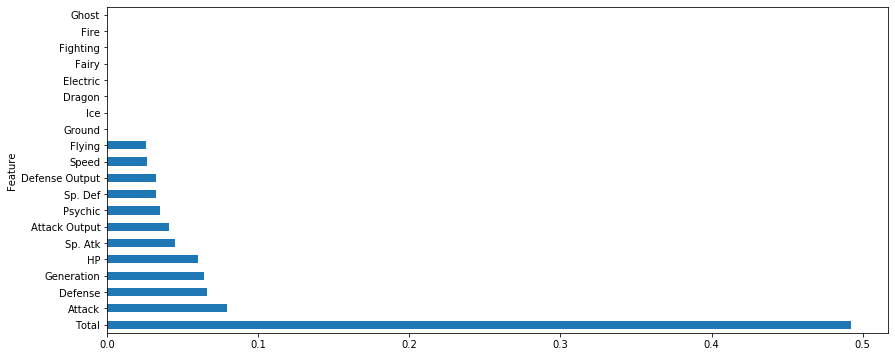

In [14]:
plot1 = fi[:20].plot('Feature', 'Importance', figsize=(14,6), legend=False, kind = 'barh')
plot1;

**Sampling**
- Combine sampling to balance the dataset

**TODO:**
- Check whether combine sampling or undersampling, which method is better
- SMOTEENN


In [ ]:
# Oversampling and undersampling 
# SMOTEENN
Y = df["Legendary"].tolist() # extract the label
X = df.drop(columns = ["Legendary"]).values.tolist()
key = df.drop(columns = ["Legendary"]).keys()


rus = imblearn.combine.SMOTEENN()  # using SMOTEENN
X_rus, Y_rus = rus.fit_sample(X, Y)

SMOTEENN_df = pandas.DataFrame(X_rus, columns = key)  # Convert back to original dataset
SMOTEENN_df["Legendary"] = Y_rus
print(Counter(Y_rus))



In [15]:
# Oversampling and undersampling 
# SMOTE
Y = df["Legendary"].tolist() # extract the label
X = df.drop(columns = ["Legendary"]).values.tolist()
key = df.drop(columns = ["Legendary"]).keys()


# rus = imblearn.combine.SMOTEENN()  # using SMOTEENN
# X_rus, Y_rus = rus.fit_sample(X, Y)

# rus = imblearn.over_sampling.SMOTE(ratio={1: 500 }, random_state=1)
rus = imblearn.over_sampling.ADASYN(ratio={1: 300 }, random_state=0)
# rus = imblearn.over_sampling.KMeansSMOTE()


X_rus, Y_rus = rus.fit_sample(X, Y)


SMOTEENN_df = pandas.DataFrame(X_rus, columns = key)  # Convert back to original dataset
SMOTEENN_df["Legendary"] = Y_rus

print(Counter(Y_rus))

Counter({0: 1109, 1: 301})


**PCA**
- PCA to visualisation the dataset

In [ ]:
# PCA
Y = df["Legendary"].tolist()
PCA_df = df.drop(columns = "Legendary")

pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(PCA_df)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["target"] = Y

In [ ]:
# Before Sampling

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

In [ ]:
# After Sampling
# PCA
Y = SMOTEENN_df["Legendary"].tolist()
PCA_df = SMOTEENN_df.drop(columns = "Legendary")

pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(PCA_df)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["target"] = Y

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

**Create Dataset**
- Train & Test
- Ledgendary and non-Ledgendary

In [16]:
df = SMOTEENN_df
header = df.keys()
# df.groupby("Legendary").count()

In [17]:
df["Legendary"].value_counts()

0    1109
1     301
Name: Legendary, dtype: int64

In [20]:
dataset = shuffle(df) #shuffle

Test_X = dataset[:100].drop(columns = ["Legendary"])
Test_Y = dataset[:100]["Legendary"]

Train_X = dataset[100:].drop(columns = ["Legendary"])
Train_Y = dataset[100:]["Legendary"]



print(Counter(Test_Y))
print(Counter(Train_Y))

Counter({0: 77, 1: 23})
Counter({0: 1032, 1: 278})


**Neural Network**
- Train & Test
- Confusion matrix
- Plot 

**TODO**
- Learning rate method

In [61]:
clf = MLPClassifier(solver='lbfgs',  # weight optimization
                    activation='tanh',  # activation function
                    alpha=10, # Regularizer value
                    hidden_layer_sizes=(10,7,5), # layer and node (node,node) --> numbers of layers
                    random_state=1, #random state
                    max_iter = 500, # max iteration
                    early_stopping = True) # early stop
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# clf = MLPClassifier(solver='adam', activation='relu', alpha=1e-5, hidden_layer_sizes=(10,7), random_state=1, max_iter = 500, early_stopping = True)





clf.fit(Train_X, Train_Y) # fit the neural network


MLPClassifier(activation='tanh', alpha=10, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(10, 7, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [62]:
clf.score(Train_X, Train_Y) # Training score

0.9496183206106871

In [63]:
clf.score(Test_X, Test_Y) # Testing Score

0.89

In [66]:
print(sklearn.metrics.classification_report(Train_Y, clf.predict(Train_X)) )

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1032
           1       0.85      0.92      0.89       278

    accuracy                           0.95      1310
   macro avg       0.92      0.94      0.93      1310
weighted avg       0.95      0.95      0.95      1310



In [67]:
# confusion matrix
print(sklearn.metrics.classification_report(Test_Y, clf.predict(Test_X)) )

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        77
           1       0.73      0.83      0.78        23

    accuracy                           0.89       100
   macro avg       0.84      0.87      0.85       100
weighted avg       0.90      0.89      0.89       100



#### Naive Bayes

In [41]:
NB = MultinomialNB(class_prior = [1, 0.58], alpha = 0.8)
NB.fit(Train_X, Train_Y)
NB.score(Train_X, Train_Y)

0.8038167938931298

In [42]:
print(sklearn.metrics.classification_report(Train_Y, NB.predict(Train_X)) )

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1032
           1       0.54      0.55      0.54       278

    accuracy                           0.80      1310
   macro avg       0.71      0.71      0.71      1310
weighted avg       0.81      0.80      0.80      1310



In [43]:
print(sklearn.metrics.classification_report(Test_Y, NB.predict(Test_X)) )

              precision    recall  f1-score   support

           0       0.86      0.83      0.85        77
           1       0.50      0.57      0.53        23

    accuracy                           0.77       100
   macro avg       0.68      0.70      0.69       100
weighted avg       0.78      0.77      0.77       100



**Decision Tree**

In [69]:
# decision tree 
clf = sklearn.tree.DecisionTreeClassifier()
clf = clf.fit(Train_X, Train_Y)

In [70]:
clf.score(Test_X, Test_Y) # Testing Score

0.95

[Text(127.25429864253394, 211.04470588235293, 'X[18] <= 0.666\nentropy = 0.334\nsamples = 1310\nvalue = [1032, 278]'),
 Text(115.13484162895926, 198.25411764705882, 'entropy = 0.0\nsamples = 957\nvalue = [957, 0]'),
 Text(139.37375565610859, 198.25411764705882, 'X[22] <= 0.332\nentropy = 0.335\nsamples = 353\nvalue = [75, 278]'),
 Text(115.13484162895926, 185.4635294117647, 'X[20] <= 0.619\nentropy = 0.363\nsamples = 21\nvalue = [16, 5]'),
 Text(103.01538461538462, 172.6729411764706, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(127.25429864253394, 172.6729411764706, 'entropy = 0.0\nsamples = 16\nvalue = [16, 0]'),
 Text(163.6126696832579, 185.4635294117647, 'X[24] <= 0.243\nentropy = 0.292\nsamples = 332\nvalue = [59, 273]'),
 Text(151.49321266968326, 172.6729411764706, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(175.73212669683258, 172.6729411764706, 'X[25] <= 0.402\nentropy = 0.272\nsamples = 326\nvalue = [53, 273]'),
 Text(96.95565610859728, 159.88235294117646, 'X[1

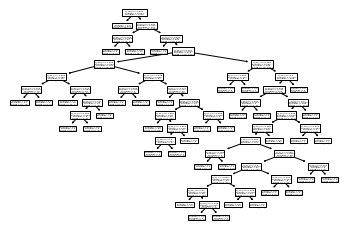

In [71]:
sklearn.tree.plot_tree(clf.fit(Train_X, Train_Y)) 

In [72]:
print(sklearn.metrics.classification_report(Test_Y, clf.predict(Test_X)) )

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        77
           1       0.88      0.96      0.92        23

    accuracy                           0.96       100
   macro avg       0.93      0.96      0.95       100
weighted avg       0.96      0.96      0.96       100



In [ ]:
path = sklearn.tree.export.export_text(clf)
print(path)

In [ ]:
# export the pdf

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_pdf('original_tree.pdf')
# pydot_graph.set_size('"5,5!"')
# pydot_graph.write_png('resized_tree.png')